In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geodatasets

# Import database (Ember - Yearly electricity data - 2025/08/09)

In [31]:
df = pd.read_csv("yearly_full_release_long_format.csv")
print (df.columns)
print(df["Category"].unique())
print(df["Continent"].unique())

Index(['Area', 'ISO 3 code', 'Year', 'Area type', 'Continent', 'Ember region',
       'EU', 'OECD', 'G20', 'G7', 'ASEAN', 'Category', 'Subcategory',
       'Variable', 'Unit', 'Value', 'YoY absolute change', 'YoY % change'],
      dtype='object')
['Capacity' 'Electricity demand' 'Electricity generation'
 'Electricity imports' 'Power sector emissions']
['Asia' nan 'Europe' 'Africa' 'Oceania' 'North America' 'South America']


In [38]:

# Define which variables belong to which aggregated categories
CATEGORY_MAPPING = {
    'Fossil': ['Coal', 'Gas', 'Other Fossil'],
    'Nuclear': ['Nuclear'],
    'Renewable': ['Bioenergy', 'Hydro', 'Other Renewables', 'Solar', 'Wind']
}

# Filter the DataFrame
filtered_df = df[
    (df['Year'] == 2023) & 
    (df['Category'] == 'Electricity generation') & 
    (df['Subcategory'] == 'Fuel') &
    (df['Unit'] == '%')
]

# Create the nested dictionary structure
result_dict = {}
for _, row in filtered_df.iterrows():
    iso_code = row['ISO 3 code']
    variable = row['Variable']
    value = row['Value']
    
    if iso_code not in result_dict:
        result_dict[iso_code] = {}
    
    # Add the original variable
    result_dict[iso_code][variable] = value


# Now add the aggregated categories
for iso_code in result_dict:
    for agg_category, subcategories in CATEGORY_MAPPING.items():
        # Sum only the subcategories that exist for this country
        total = sum(result_dict[iso_code].get(sub, 0) for sub in subcategories)
        result_dict[iso_code][agg_category] = total

       
print (result_dict["PRY"])
print (result_dict["ESP"]["Nuclear"] + result_dict["ESP"]["Fossil"] + result_dict["ESP"]["Renewable"])

{'Bioenergy': 0.54, 'Coal': 0.0, 'Gas': 0.0, 'Hydro': 99.46, 'Nuclear': 0.0, 'Other Fossil': 0.0, 'Other Renewables': 0.0, 'Solar': 0.0, 'Wind': 0.0, 'Fossil': 0.0, 'Renewable': 100.0}
99.98


In [39]:
countries_shares = {
    iso_code: (
        round(data.get('Fossil', 0) / total if (total := data.get('Fossil', 0) + data.get('Renewable', 0) + data.get('Nuclear', 0)) > 0 else 0.0, 2),
        round(data.get('Renewable', 0) / total if total > 0 else 0.0, 2),
        round(data.get('Nuclear', 0) / total if total > 0 else 0.0, 2)
    )
    for iso_code, data in result_dict.items()
}

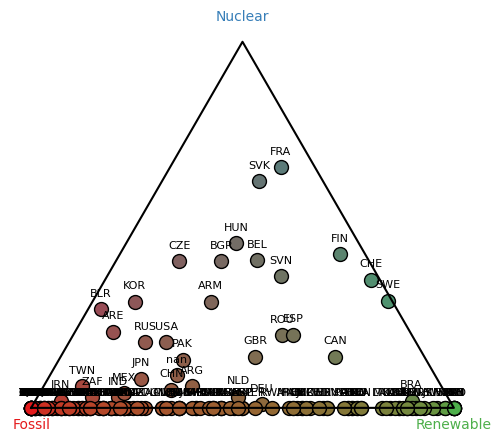

In [48]:

# Colors for vertices
base_colors = {
    'fossil': (228, 26, 28),    # red
    'renewable': (77, 175, 74), # green
    'nuclear': (55, 126, 184)   # blue
}


# Colors for vertices
#base_colors = {    'fossil': (255, 0,0),'renewable': (0, 255, 0),'nuclear': (0, 0, 255)}

# Caps for each category
caps = {
    'fossil': 1,#0.85,
    'renewable': 1,#0.70,
    'nuclear': 1,#0.65
}

def ternary_to_rgb_scaled(fossil, renewable, nuclear, colors, caps, gamma=.5):
    # Apply caps
    f = min(fossil, caps['fossil'])
    r = min(renewable, caps['renewable'])
    n = min(nuclear, caps['nuclear'])
    
    # Normalize after caps
    total = f + r + n

    try:
        f, r, n = f/total, r/total, n/total
        
        # Non-linear scaling
        f_gamma = f**gamma
        r_gamma = r**gamma
        n_gamma = n**gamma
        
        # Renormalize
        total_gamma = f_gamma + r_gamma + n_gamma
        f_norm, r_norm, n_norm = f_gamma/total_gamma, r_gamma/total_gamma, n_gamma/total_gamma
        
        # Blend colors
        f_color = np.array(colors['fossil'])
        r_color = np.array(colors['renewable'])
        n_color = np.array(colors['nuclear'])
        rgb = f_norm * f_color + r_norm * r_color + n_norm * n_color
        return rgb.astype(int) / 255
    except ZeroDivisionError:
        f_color = np.array(colors['fossil'])
        r_color = np.array(colors['renewable'])
        n_color = np.array(colors['nuclear'])
        rgb = 0 * f_color + 0 * r_color + 0 * n_color
        return rgb.astype(int) / 255


# Convert ternary (fossil, renewable, nuclear) to 2D cartesian coords
def ternary_to_cartesian(f, r, n):
    x = 0.5 * (2*r + n) / (f + r + n)
    y = (np.sqrt(3)/2) * n / (f + r + n)
    return x, y

fig, ax = plt.subplots(figsize=(6, 6))

for country, (f, r, n) in countries_shares.items():
    rgb = ternary_to_rgb_scaled(f, r, n, base_colors, caps, gamma=0.5)
    x, y = ternary_to_cartesian(f, r, n)
    ax.scatter(x, y, color=rgb, s=100, edgecolor='k')
    ax.text(x, y + 0.03, country, ha='center', fontsize=8)

# Draw triangle outline
triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2], [0, 0]])
ax.plot(triangle[:,0], triangle[:,1], color='black')

# Vertex labels
ax.text(0, -0.05, "Fossil", ha='center', fontsize=10, color=np.array(base_colors['fossil'])/255)
ax.text(1, -0.05, "Renewable", ha='center', fontsize=10, color=np.array(base_colors['renewable'])/255)
ax.text(0.5, np.sqrt(3)/2 + 0.05, "Nuclear", ha='center', fontsize=10, color=np.array(base_colors['nuclear'])/255)

ax.set_aspect('equal')
ax.axis('off')
plt.show()

['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA', 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR', 'ADM0_A3_JP', 'ADM0_A3_KO', 'ADM0_A3_VN', 'ADM0_A3_TR', 'AD

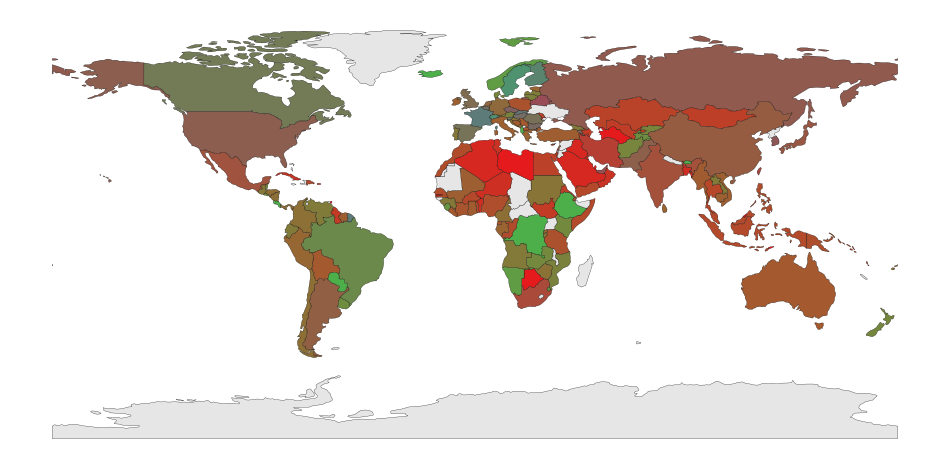

In [49]:

world = gpd.read_file("ne_110m_admin_0_countries.shp")
print (list(world.columns))

world["color"] = [
    ternary_to_rgb_scaled(*countries_shares[iso], base_colors, caps)
    if iso in countries_shares else (0.9, 0.9, 0.9)
    for iso in world["ISO_A3_EH"]
]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
world.plot(color=world["color"], ax=ax, edgecolor="black", linewidth=0.2)
ax.axis("off")
plt.show()



In [44]:
world["ISO_A3_EH"]

0      IDN
1      MYS
2      CHL
3      BOL
4      PER
      ... 
253    MAC
254    AUS
255    -99
256    -99
257    -99
Name: ISO_A3_EH, Length: 258, dtype: object

In [36]:
len(countries_shares.keys())

215

In [30]:
for year in range(2020,2025):
    filtered_df = df[
        (df['Year'] == year) & 
        (df['Continent'] == 'Africa') & 
        (df['Subcategory'] == 'Fuel') &
        (df['Unit'] == '%')
    ]
    print (year, len(filtered_df["Area"].unique()))

2020 56
2021 56
2022 56
2023 44
2024 6
